In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date,timedelta
import warnings
warnings.filterwarnings('ignore')

In [40]:
def preprocessing(filename):
    #reading the csv file
    df = pd.read_csv(filename)
    #dropping unused columns
    df = df.drop(['Tn','Tx','ff_x','ddd_x','ff_avg','ddd_car'], axis =1)

    #adjusting the date columns
    datedata = []
    df['Tanggal'] = pd.to_datetime(df['Tanggal'])   
    init = df.iloc[0]['Tanggal']
    end = df.iloc[-1]['Tanggal']
    start_date = date(init.year, init.month, init.day) 
    end_date = date(end.year, end.month, end.day) 
    delta = end_date - start_date 
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        datedata.append(day)
    df = df.drop('Tanggal',axis =1)
    df['Date']  = datedata
    df['YR'] = [d.year for d in df['Date']]
    df['MO'] = [d.month for d in df['Date']]
    df['DD'] = [d.day for d in df['Date']]

    #filling null values in each column with interpolation values
    df['Tavg'] = df['Tavg'].interpolate()
    df['RH_avg'] = df['RH_avg'].interpolate()
    df['ss'] = df['ss'].interpolate()
    df['RR'] = df['RR'].fillna(0)
    for index, value in enumerate(df['RR']):
        if value == 8888:
            df['RR'][index] = np.nan
        elif value == 9999:
            df['RR'][index] = np.nan
    df['RR'] = df['RR'].fillna(0)
    df = df[['Date', 'YR','MO','DD','Tavg','RH_avg','RR','ss']]
    return df

In [41]:
df = preprocessing('CUACA MALANG 2000-2021.csv')
df

,Date,YR,MO,DD,Tavg,RH_avg,RR,ss
0,2000-01-01,2000,1,1,24.1,69.0,82.0,5.4
1,2000-01-02,2000,1,2,22.9,77.0,0.0,1.2
2,2000-01-03,2000,1,3,23.8,78.0,14.0,4.1
3,2000-01-04,2000,1,4,24.2,77.0,10.0,1.3
4,2000-01-05,2000,1,5,23.4,78.0,0.0,3.6
...,...,...,...,...,...,...,...,...
8121,2022-03-27,2022,3,27,23.2,88.0,3.0,1.6
8122,2022-03-28,2022,3,28,23.8,82.0,4.7,0.7
8123,2022-03-29,2022,3,29,23.8,84.0,5.0,7.5
8124,2022-03-30,2022,3,30,24.8,79.0,3.4,4.7


In [47]:
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def timeseriesplots(x,y,title):
    fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(nrows = 2, ncols = 2,figsize = (16,7))
    ax2.hist(y)
    ax2.set_title(title + ' Histogram')
    ax1.plot(x,y)
    ax1.set_title(title + ' per Year')
    plot_acf(y, ax = ax3, title= 'Autocorrelation Graph for ' + title)
    plot_pacf(y, ax = ax4,title= 'Partial Autocorrelation Graph for ' + title)

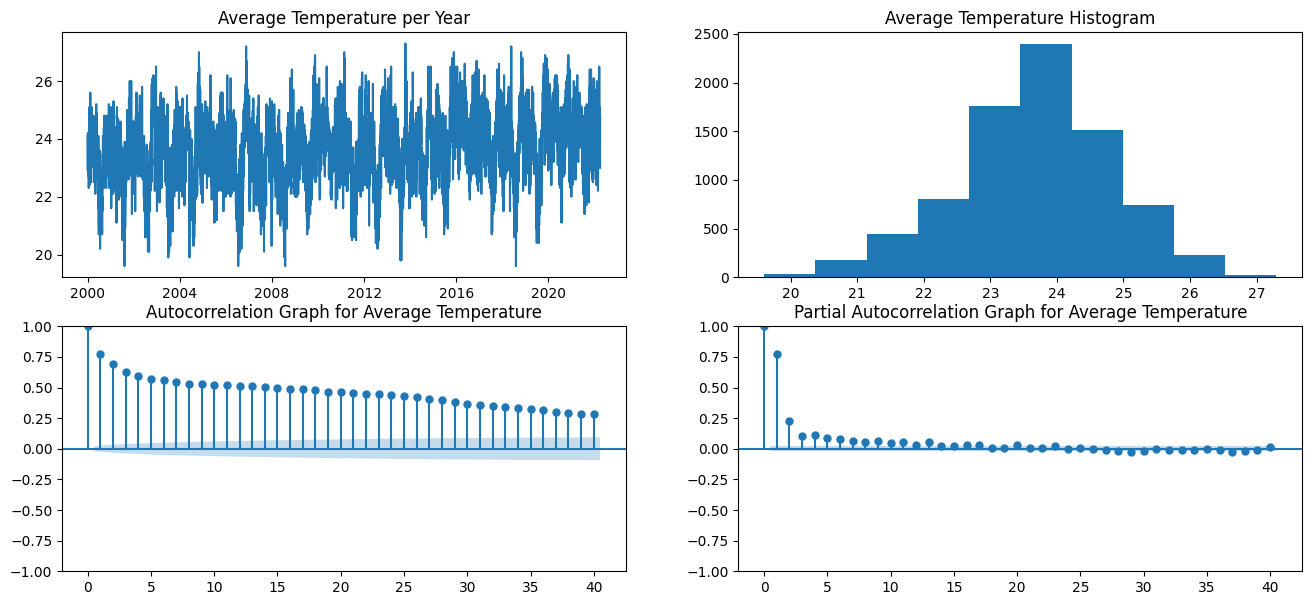

In [48]:
timeseriesplots(df['Date'], df['Tavg'], title ='Average Temperature')

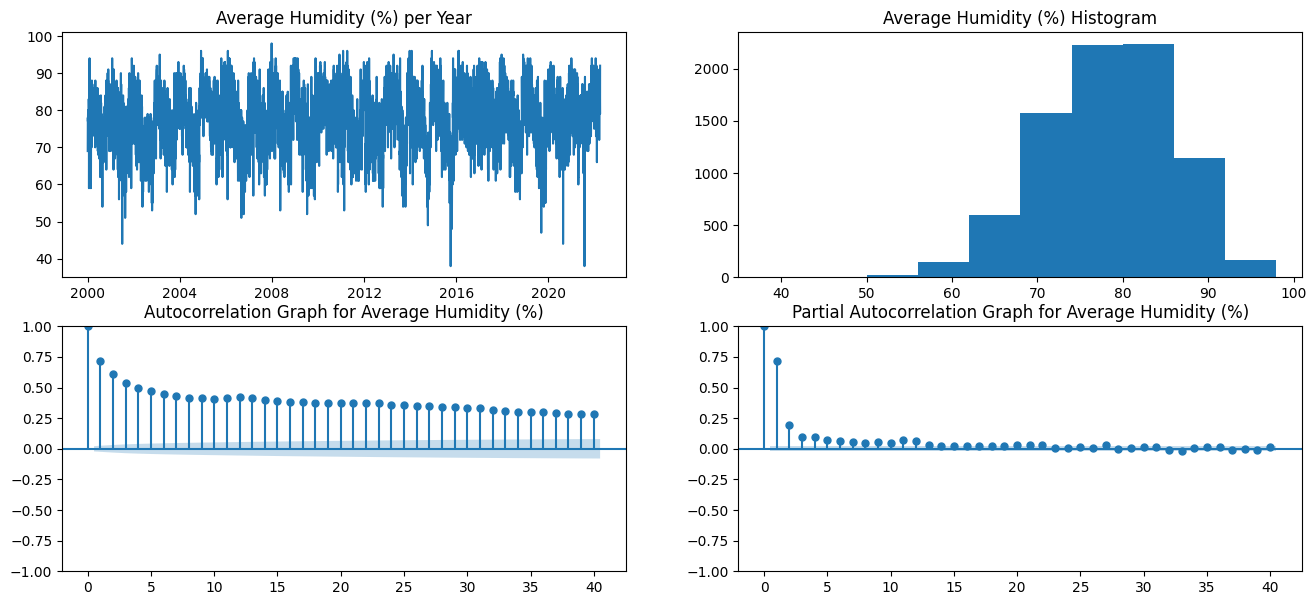

In [49]:
timeseriesplots(df['Date'], df['RH_avg'], title ='Average Humidity (%)')

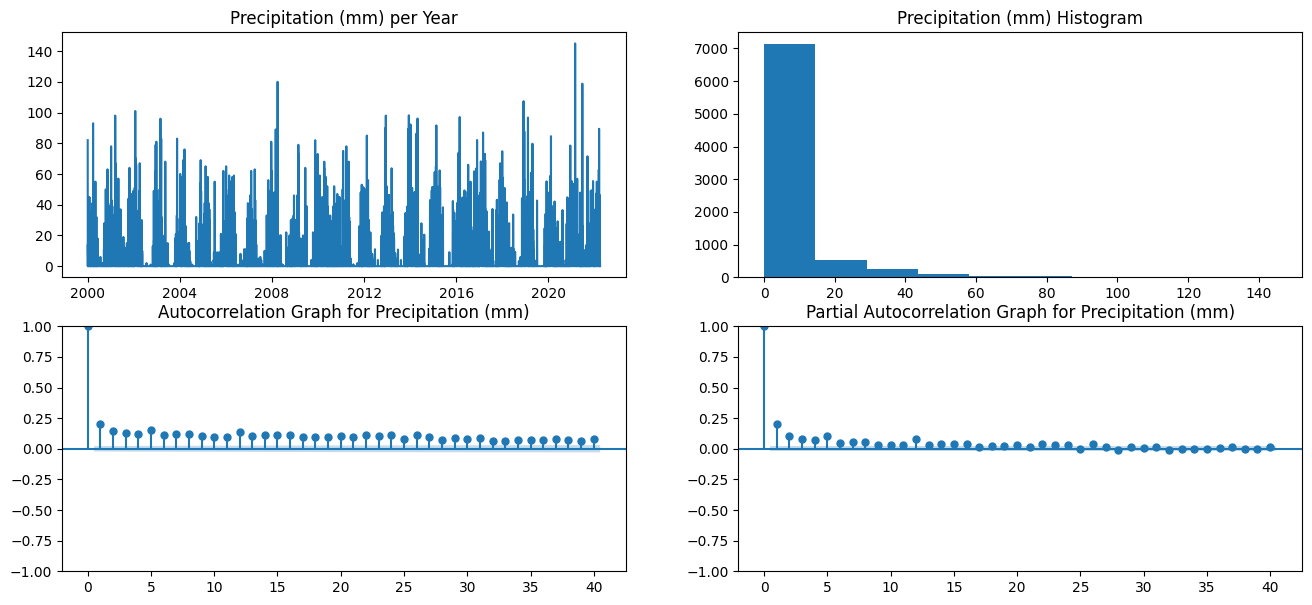

In [50]:
timeseriesplots(df['Date'], df['RR'], title ='Precipitation (mm)')

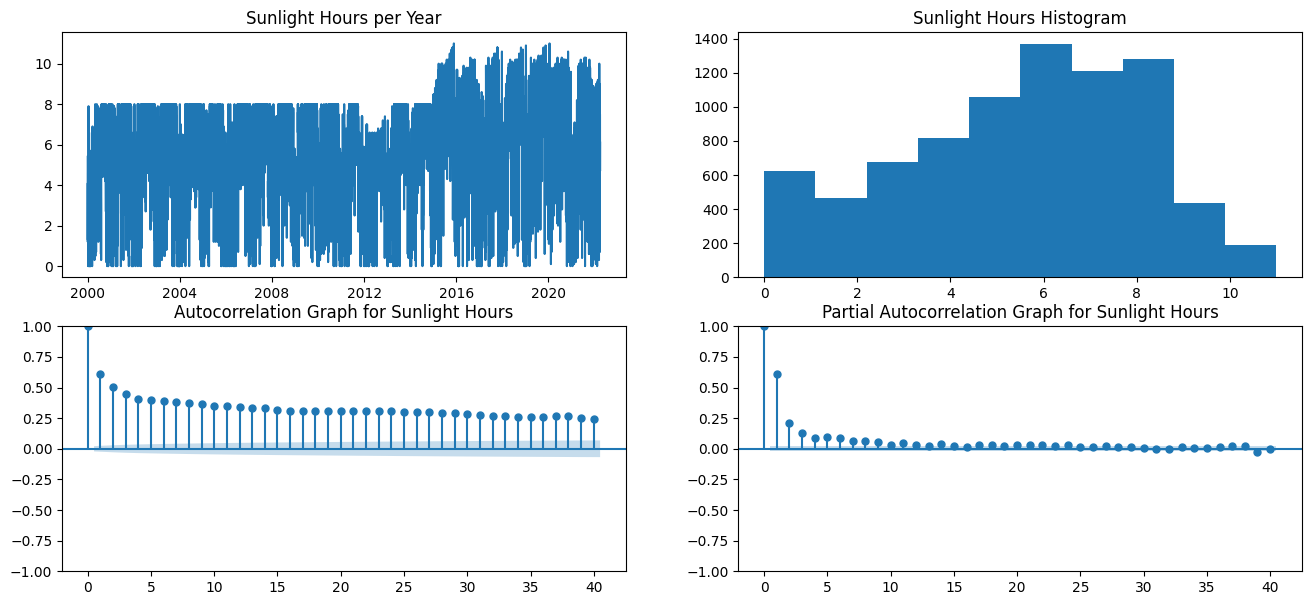

In [51]:
timeseriesplots(df['Date'], df['ss'], title ='Sunlight Hours')

In [52]:
df_decomp = df.set_index('Date', drop = True)
df_decomp

,YR,MO,DD,Tavg,RH_avg,RR,ss
Date,,,,,,,
2000-01-01,2000,1,1,24.1,69.0,82.0,5.4
2000-01-02,2000,1,2,22.9,77.0,0.0,1.2
2000-01-03,2000,1,3,23.8,78.0,14.0,4.1
2000-01-04,2000,1,4,24.2,77.0,10.0,1.3
2000-01-05,2000,1,5,23.4,78.0,0.0,3.6
...,...,...,...,...,...,...,...
2022-03-27,2022,3,27,23.2,88.0,3.0,1.6
2022-03-28,2022,3,28,23.8,82.0,4.7,0.7
2022-03-29,2022,3,29,23.8,84.0,5.0,7.5


In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decomposeplot(x,title):
    seasonal = seasonal_decompose(x, model='additive', period= int(len(df_decomp)/2))
    trend_estimate    = seasonal.trend
    periodic_estimate = seasonal.seasonal
    residual          = seasonal.resid
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(x, label = 'Original ' + title, color = 'b')
    plt.plot(trend_estimate, label = 'Trend of '+ title, color = 'r')
    plt.title(title +' and Trend Graph')
    plt.legend()
    plt.subplot(222)
    plt.plot(trend_estimate, label = 'Trend of ' + title, color = 'r')
    plt.title('Trend of ' + title)
    plt.subplot(223)
    plt.plot(periodic_estimate, label = 'Seasonality of  '+ title, color = 'b')
    plt.title('Seasonality of  '+ title)
    plt.subplot(224)
    plt.plot(residual, label = 'Residual of ' + title, color = 'b')
    plt.title('Residual of ' + title)
    plt.ylim(-0.08,0.05)

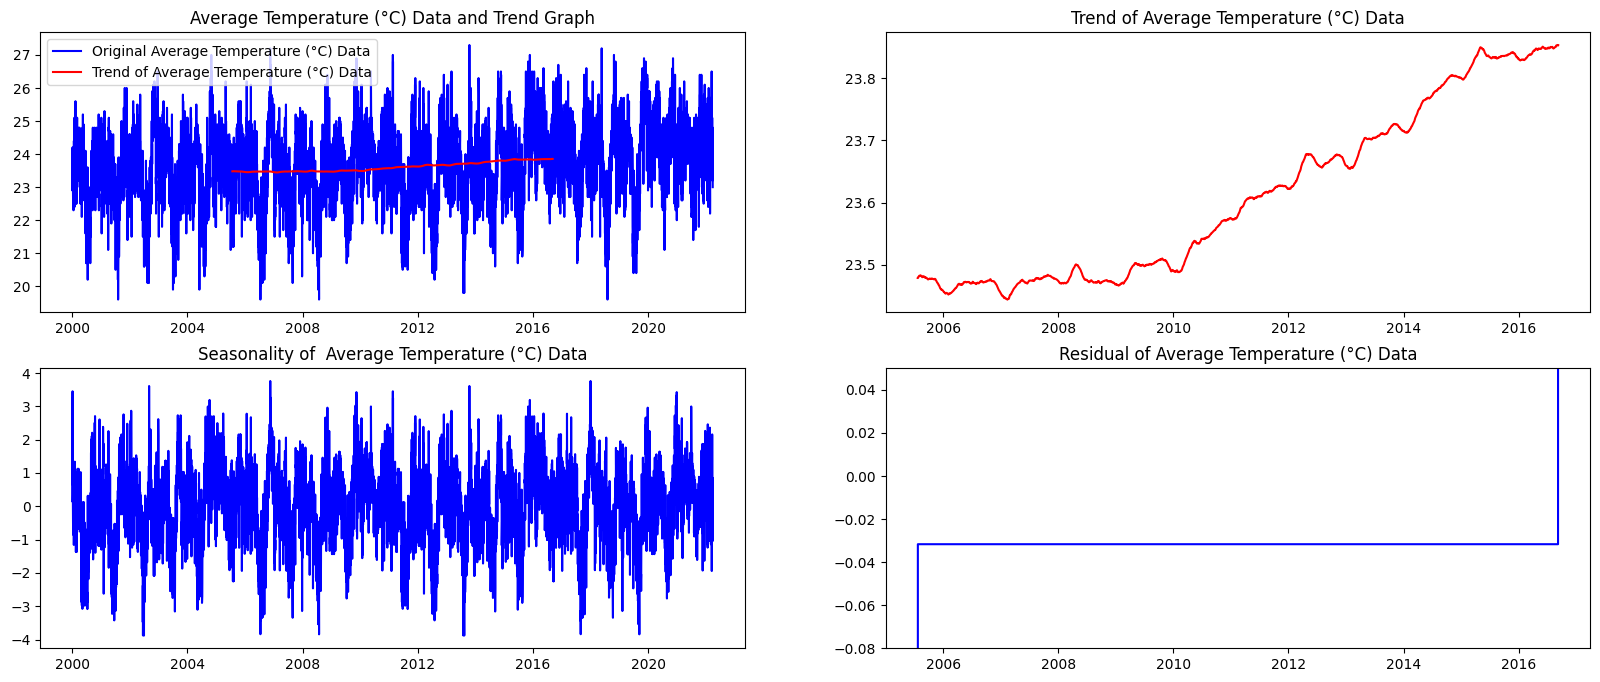

In [54]:
decomposeplot(df_decomp['Tavg'], title = 'Average Temperature (°C) Data')

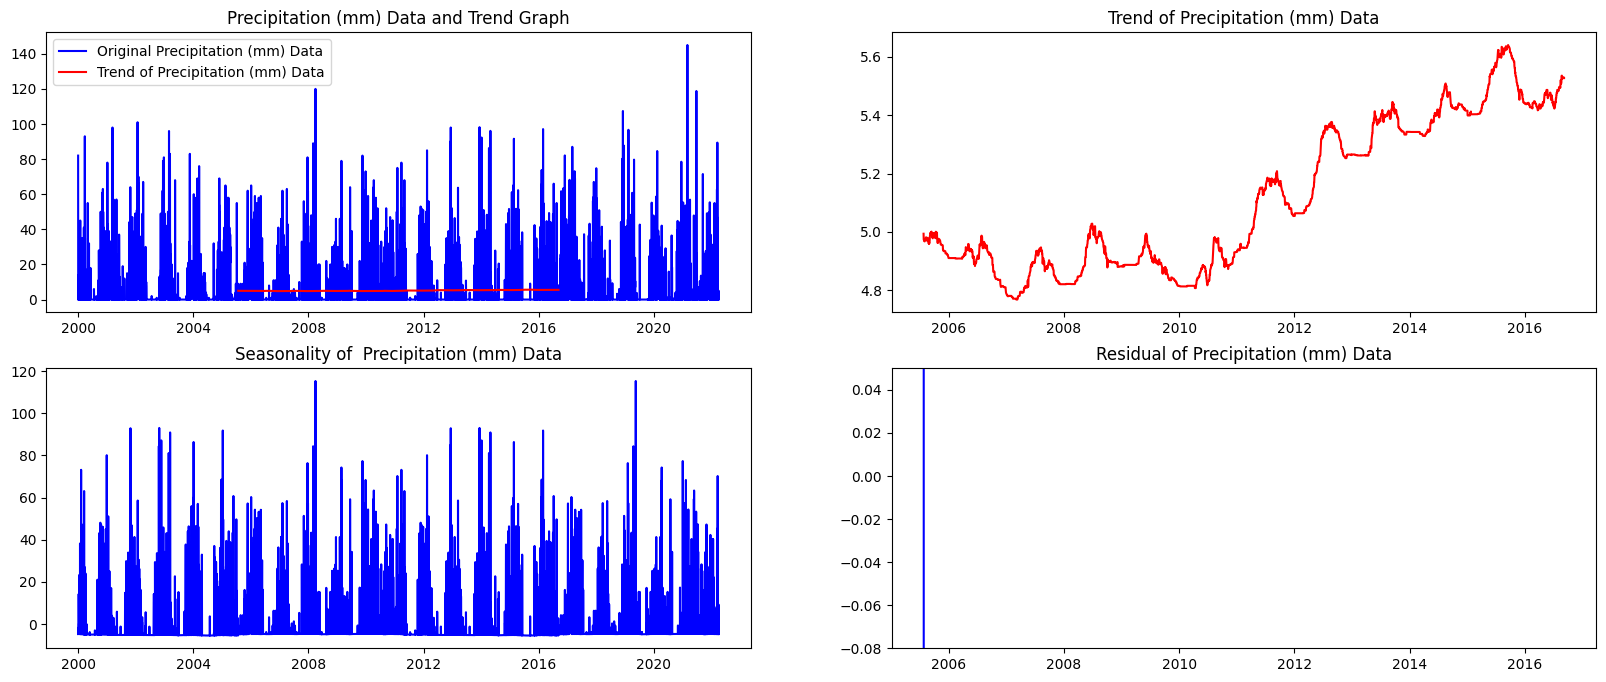

In [55]:
decomposeplot(df_decomp['RR'], title = 'Precipitation (mm) Data')

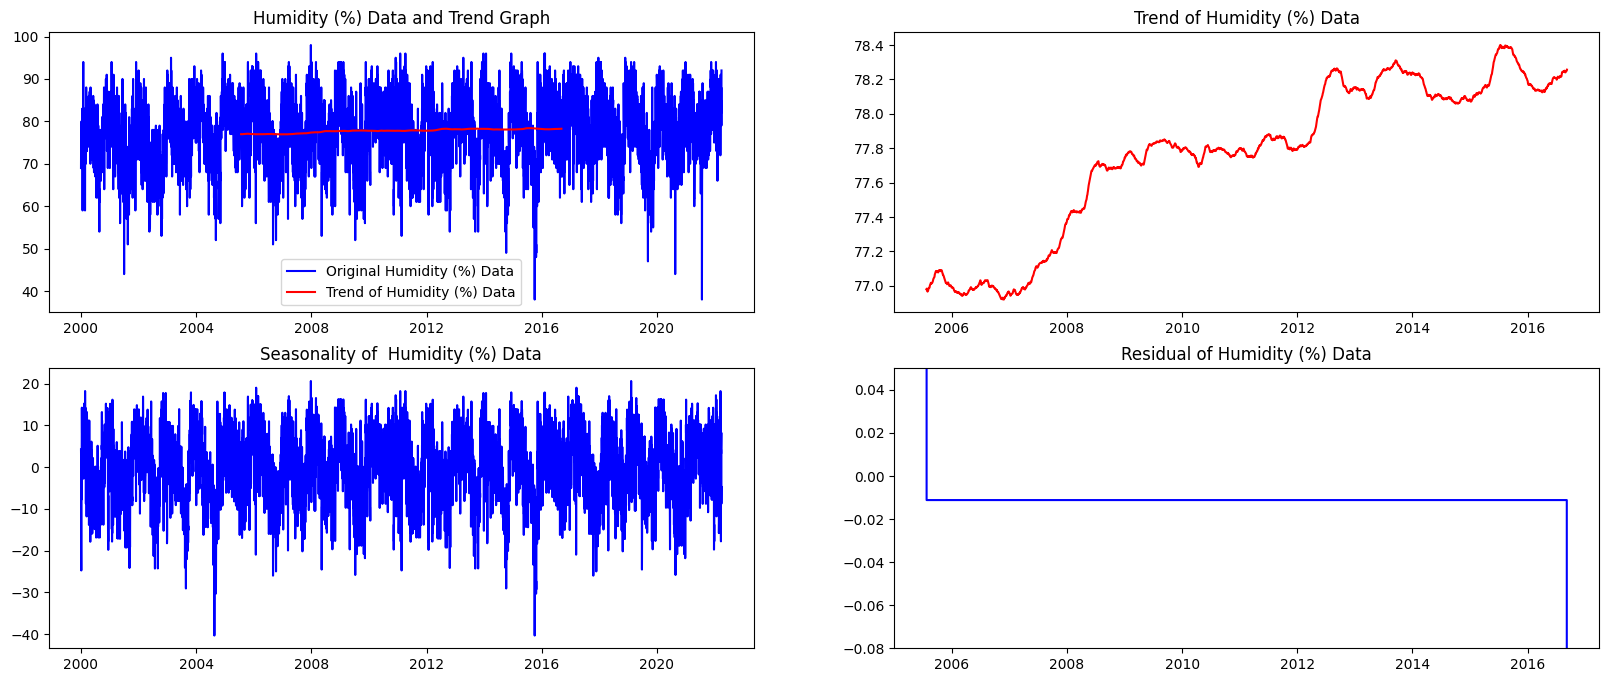

In [56]:
decomposeplot(df_decomp['RH_avg'], title = 'Humidity (%) Data')

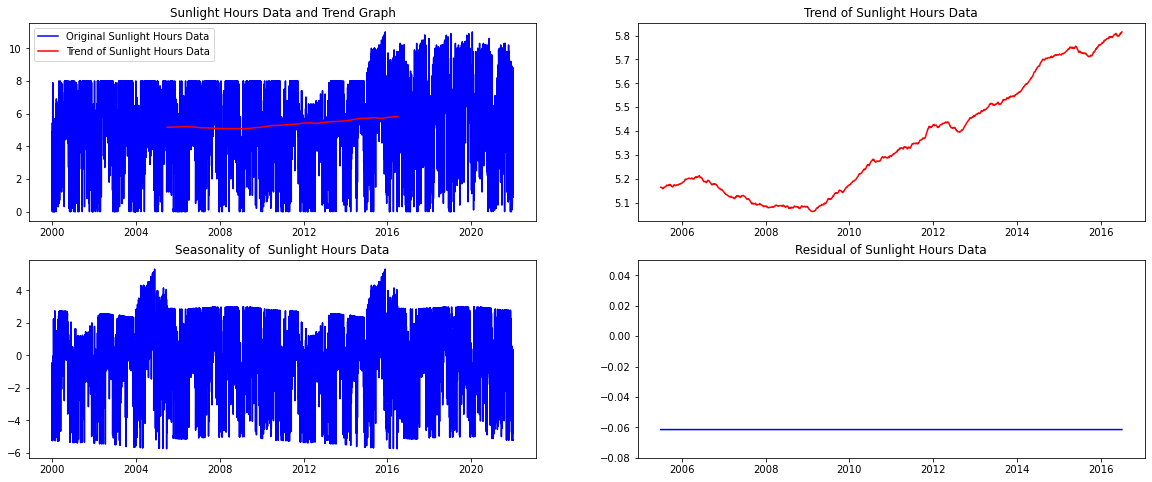

In [20]:
decomposeplot(df_decomp['ss'], title = 'Sunlight Hours Data')

<AxesSubplot: >

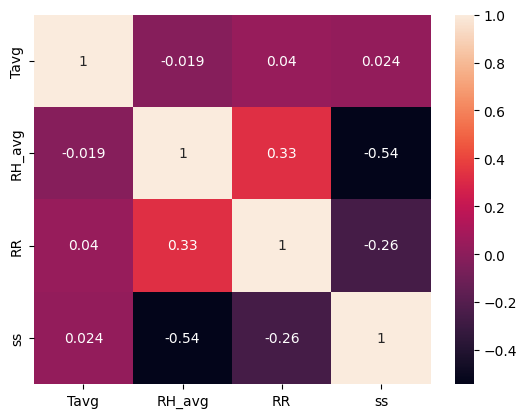

In [59]:
df_corr = df.drop(['Date','YR','MO','DD'],axis =1)
correlations = df_corr.corr()
sns.heatmap(correlations, annot = True)